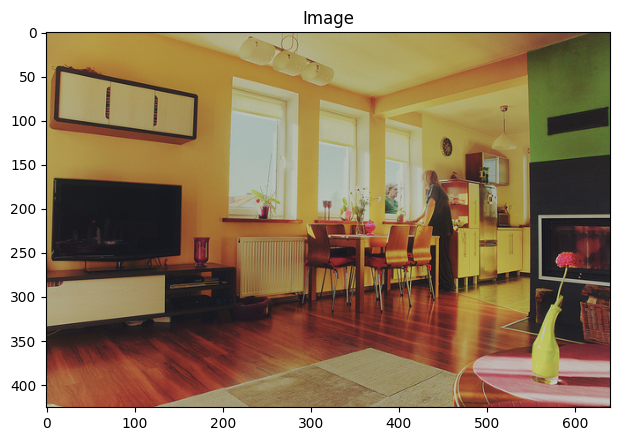

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("val2017/000000000139.jpg")
# mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))

# plt.subplot(122)
# plt.title("Mask")
# plt.imshow(mask.permute(1, 2, 0))

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from torchvision.transforms import functional as F
from torchvision import transforms as T

from torchvision.transforms import v2 as T2

class Coco2017Dataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        """
        Args:
            root (string): Đường dẫn đến thư mục chứa ảnh.
            annotation_file (string): Đường dẫn đến file annotation COCO JSON.
            transforms (callable, optional): Hàm biến đổi áp dụng cho ảnh và target.
        """
        self.root = root
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, idx):
        # Lấy thông tin ảnh từ COCO
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Lấy annotations cho ảnh
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Khởi tạo danh sách bounding boxes và masks
        num_objs = len(anns)
        boxes = []
        masks = []
        labels = []
        for ann in anns:
            # Bounding box
            bbox = ann['bbox']
            x, y, width, height = bbox
            xmin, ymin, xmax, ymax = x, y, x + width, y + height
            boxes.append([xmin, ymin, xmax, ymax])

            # Mask (chuyển đổi từ binary mask)
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            # Class label
            labels.append(ann['category_id'])

        # Chuyển đổi sang tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        # Tính diện tích và xác định đối tượng
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])

        # Tạo target dict
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_ids)

/home/damnt055/anaconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/damnt055/anaconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

In [3]:
import utils.transforms as U

def get_transform(train):
    transforms = []
    transforms.append(U.PILToTensor())
    transforms.append(U.ConvertImageDtype(torch.float))
    if train:
        transforms.append(U.RandomHorizontalFlip(0.5))
    return U.Compose(transforms)

In [4]:
# Tạo dataset và dataloader
dataset = Coco2017Dataset(
    annotation_file='annotations_trainval2017/annotations/instances_val2017.json',
    root='./val2017',
    transforms=get_transform(train=False)
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1,
    collate_fn=lambda x: tuple(zip(*x))  # Tuỳ chỉnh collate_fn nếu cần
)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [5]:
# For Training
images,targets = next(iter(dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
print(len(images), len(targets))

/tmp/ipykernel_57571/4229196134.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


4 4


: 

In [6]:
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn_v2
model = retinanet_resnet50_fpn_v2(weights='DEFAULT')

output = model(images, targets)